## Collision Insights

In [28]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import re
import json

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, lit, hour, dayofweek, date_format, sum, dayofyear, year

In [2]:
print("Initializing Spark Session...")
spark = SparkSession.builder \
    .appName("CollisionInsights") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()
print("Spark Session initialized.")

linux_path = "/home/paul/projects/collision-insights/data/US_Accidents_March23.csv"
windows_path = "C:\\Users\\aaeam\\Documents\\collision-insights\\data\\US_Accidents_March23.csv"
# Automatically set the correct file path
csv_file_path = linux_path if os.name == "posix" else windows_path

print(f"Loading data from {csv_file_path}...")
try:
    df = spark.read \
        .option("header", True) \
        .option("inferSchema", True) \
        .csv(csv_file_path)
    print("Data loaded successfully.")
    print(f"Number of partitions: {df.rdd.getNumPartitions()}")
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    exit()

Initializing Spark Session...


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/05 22:08:35 WARN Utils: Your hostname, paul-Alienware-Aurora-Ryzen-Edition, resolves to a loopback address: 127.0.1.1; using 192.168.1.8 instead (on interface wlp5s0)
25/06/05 22:08:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/05 22:08:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session initialized.
Loading data from /home/paul/projects/collision-insights/data/US_Accidents_March23.csv...


Data loaded successfully.
Number of partitions: 23


## Basic EDA

In [19]:
# Basic Data Exploration

print("\n--- DataFrame Schema ---")
df.printSchema()

# print("\n--- First 5 Rows ---")
# df.show(5, truncate=False)

print("\n--- Total Number of Records ---")
num_records = df.count()
print(f"Total records: {num_records}")

#TODO fix - this is showing a bunch of columns that just incorrectly have numbers like description
print("\n--- Statistics for Numerical Columns ('Describe') ---")
# This can take some time for very large datasets
df.describe().show(truncate=False)

print("\n--- Check for Null Values (Top Columns with Nulls) ---")
# Calculate null counts for each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Filter and show columns with any nulls
null_counts_df = null_counts.toPandas().transpose()
null_counts_df.columns = ['null_count']
null_columns_with_values = null_counts_df[null_counts_df['null_count'] > 0]

print(null_columns_with_values.sort_values(by='null_count', ascending=False))


--- DataFrame Schema ---
root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): doubl

25/06/05 23:13:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------+-------+------------------+-----------------+------------------+-----------------+------------------+------------------+----------------------------------------------------------------------------------------+------------------+----------+---------+-------+------------------+-------+----------+------------+------------------+-----------------+------------------+------------------+-----------------+--------------+-----------------+--------------------+------------------+--------------+--------------+-----------------+---------------------+
|summary|ID      |Source |Severity          |Start_Lat        |Start_Lng         |End_Lat          |End_Lng           |Distance(mi)      |Description                                                                             |Street            |City      |County   |State  |Zipcode           |Country|Timezone  |Airport_Code|Temperature(F)    |Wind_Chill(F)    |Humidity(%)       |Pressure(in)      |Visibility(mi)   |Wind_Direction|Win

                       null_count
End_Lat                   3402762
End_Lng                   3402762
Precipitation(in)         2203586
Wind_Chill(F)             1999019
Wind_Speed(mph)            571233
Visibility(mi)             177098
Wind_Direction             175206
Humidity(%)                174144
Weather_Condition          173459
Temperature(F)             163853
Pressure(in)               140679
Weather_Timestamp          120228
Sunrise_Sunset              23246
Civil_Twilight              23246
Nautical_Twilight           23246
Astronomical_Twilight       23246
Airport_Code                22635
Street                      10869
Timezone                     7808
Zipcode                      1915
City                          253
Description                     5


In [30]:
# Field sorting - done in code for now but not USED in code yet

# Fields highly relevant for identifying patterns, trends, and factors contributing to accidents.
highly_relevant = [
    # Basic Info
    'ID',                    # Unique accident identifier.
    'Severity',              # Accident impact level, core target.
    'Start_Time',            # Accident start time, critical for temporal trends.
    'End_Time',              # Accident end time, useful for duration.
    # Weather
    'Temperature(F)',        # Direct weather factors
    'Humidity(%)',           
    'Pressure(in)',          
    'Visibility(mi)',        # Crucial
    'Precipitation(in)',     
    'Weather_Condition',     # Categorical weather summary (e.g., Rain, Snow, Clear, Fog). 145 cats in a bag
    # Road features
    'Junction',              # Presence of an intersection.
    'Crossing',              # Presence of a crossing (pedestrian, railway).
    'Traffic_Signal',        # Presence of a traffic light.
    'Stop',                  # Presence of a stop sign.
    'Bump',                  # Presence of a speed bump.
    'Traffic_Calming',       # General traffic calming measures.
    'Roundabout',            # Presence of a roundabout.
    'Give_Way',              # Presence of a 'yield' sign.
]

# Fields that might be relevant but require more careful consideration, aggregation,
# or complex analysis, or describe impact/extent rather than direct cause.
# Nearly all geographical/location based in some way
maybe_relevant = [
    'Start_Lat',             # Latitude of accident start, requires aggregation
    'Start_Lng',             # Longitude ""
    'End_Lat',               # Latitude of accident end point, high nulls, describes impact
    'End_Lng',               # Longitude ""
    'Distance(mi)',          # Length of affected road, describes impact/extent, not direct cause
    'Street',                # Street name
    'City',                  # Geographical grouping, requires aggregation
    'County',                # ""
    'State',                 
    'Zipcode',               
    'Number',                # Street number
    'Description',           # Requires NLP for structured insights.
    'Sunrise_Sunset',        # General day/night period (light conditions).
    'Civil_Twilight',        # Different measures of twilight
    'Nautical_Twilight',     
    'Astronomical_Twilight'
]

# Fields considered likely not relevant
not_relevant = [
    'Source',                # Data provider
    'Country',               # All data is US
    'Timezone',              # Times are local
    'Airport_Code',          # Nearest weather station, imputation is out of scope
    'Wind_Chill(F)',         # Redundant with Temp and Wind_Speed
    'Wind_Direction',        # Requires advanced analysis for accident correlation.
    'Amenity',               # "Is a bank nearby" very unlikely to be relevant
    'No_Exit',               # Same
    'Railway',               # Railway nearby, not a direct cause
    'Station',               # General station (bus, train), too generic.
    'Turning_Loop',          # Less common road feature, unlikely major factor.
    'Side'                   # Right/left side of street
]

In [ ]:
# This check returns all IDs unique, so no longer needed

# print("--- Checking ID Uniqueness ---")
# total_records = df.count()
# distinct_ids = df.select("ID").distinct().count()

# print(f"Total records: {total_records}")
# print(f"Distinct IDs: {distinct_ids}")

# if total_records == distinct_ids:
#     print("Conclusion: All IDs are unique. Each row represents a distinct accident.")
# else:
#     print("Conclusion: Duplicate IDs found. Further investigation needed.")

--- Checking ID Uniqueness ---


Total records: 7728394
Distinct IDs: 7728394
Conclusion: All IDs are unique. Each row represents a distinct accident.



--- Analyzing Severity Distribution ---


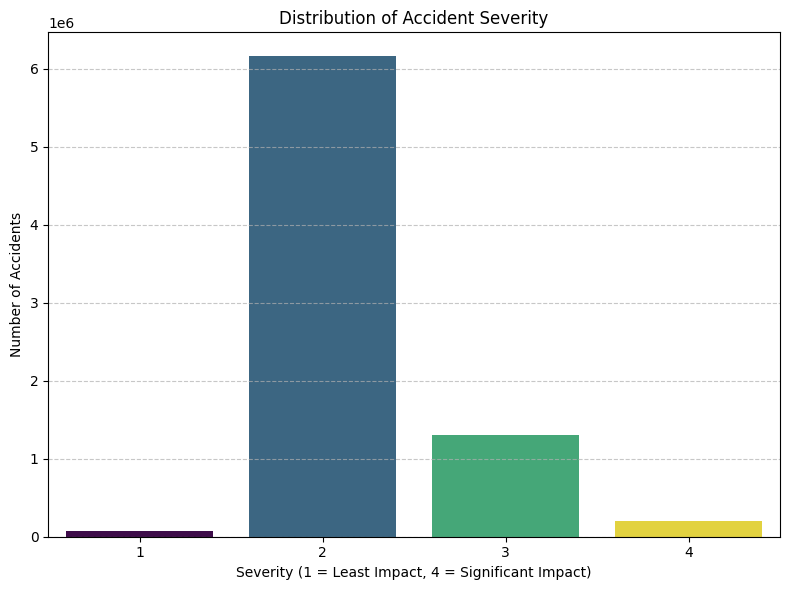

In [3]:
print("\n--- Analyzing Severity Distribution ---")

severity_counts_spark = df.groupBy("Severity").count().orderBy("Severity")
severity_counts_pd = severity_counts_spark.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x='Severity', y='count', data=severity_counts_pd, hue='Severity', palette='viridis', legend=False)

plt.title('Distribution of Accident Severity')
plt.xlabel('Severity (1 = Least Impact, 4 = Significant Impact)')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Accident Severity Distribution

There are almost no Severity 1 accidents. This may be counter-intuitive, as minor accidents happen frequently. Our assumption is that most of these accidents are simply too minor to get "noticed" in this data set.

The data is dominated by Severity 2 (~6M) and 3 (1.2M) accidents, with Severity 4 as the "rarest" (technically Severity 1 is rarer in the set, but likely under-reported). 

Severity describes the effect the accident had on **traffic** patterns, so it's important to keep in mind that a very serious or even lethal accident that takes place on a street with very little traffic would likely be rated 1, or not even appear at all.

#### Time-Based EDA


--- Analyzing Accident Frequency by Hour of Day ---


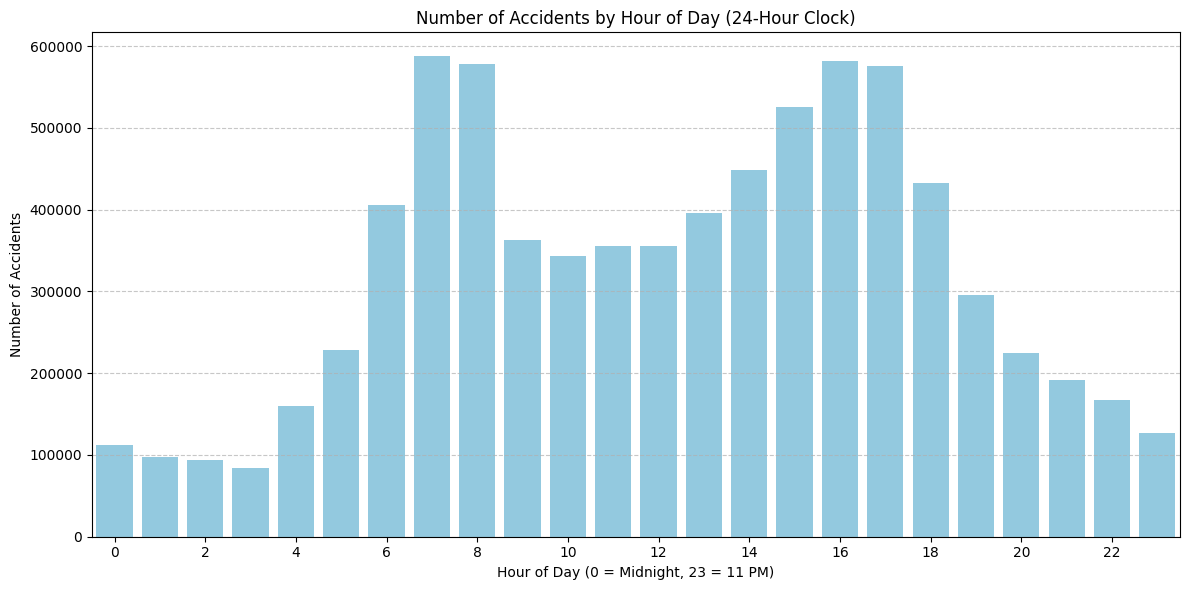

In [10]:
print("\n--- Analyzing Accident Frequency by Hour of Day ---")

df_hourly_accidents = df.withColumn("Start_Hour", hour(col("Start_Time")))
hourly_counts_spark = df_hourly_accidents.groupBy("Start_Hour").count().orderBy("Start_Hour")

# DF for plotting our evil deeds
hourly_counts_pd = hourly_counts_spark.toPandas()

all_hours = pd.DataFrame({'Start_Hour': range(24)})
hourly_counts_pd = pd.merge(all_hours, hourly_counts_pd, on='Start_Hour', how='left').fillna(0)

plt.figure(figsize=(12, 6))
sns.barplot(x='Start_Hour', y='count', data=hourly_counts_pd, color='skyblue')

plt.title('Number of Accidents by Hour of Day (24-Hour Clock)')
plt.xlabel('Hour of Day (0 = Midnight, 23 = 11 PM)')
plt.ylabel('Number of Accidents')
plt.xticks(range(0, 24, 2))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


--- Analyzing Accident Frequency for Severity 3 by Hour of Day ---


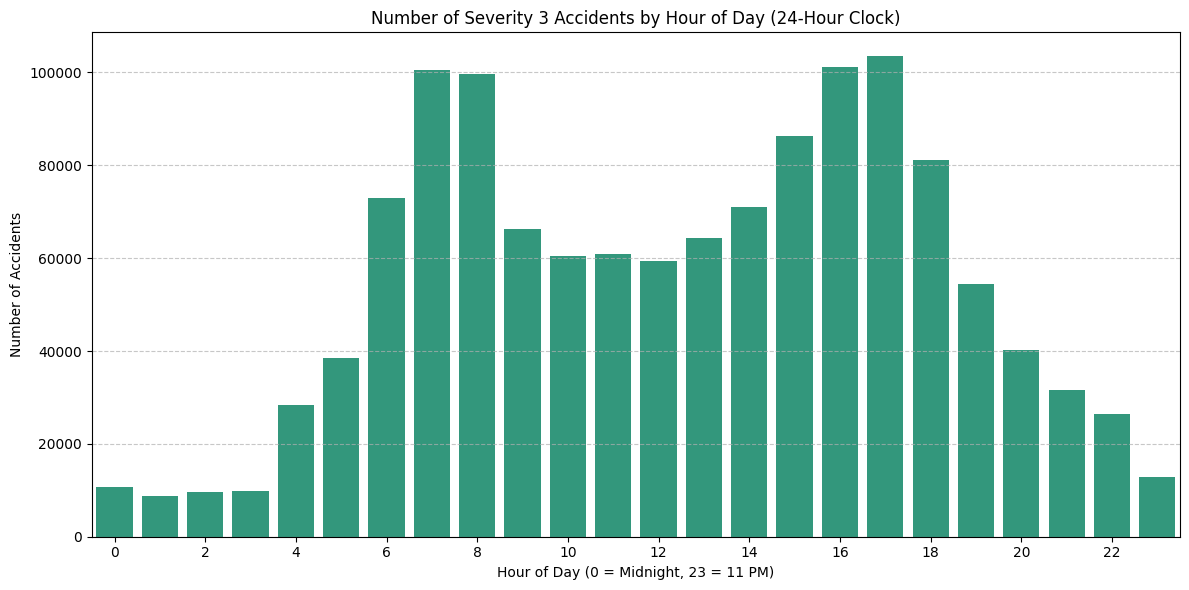


--- Analyzing Accident Frequency for Severity 4 by Hour of Day ---


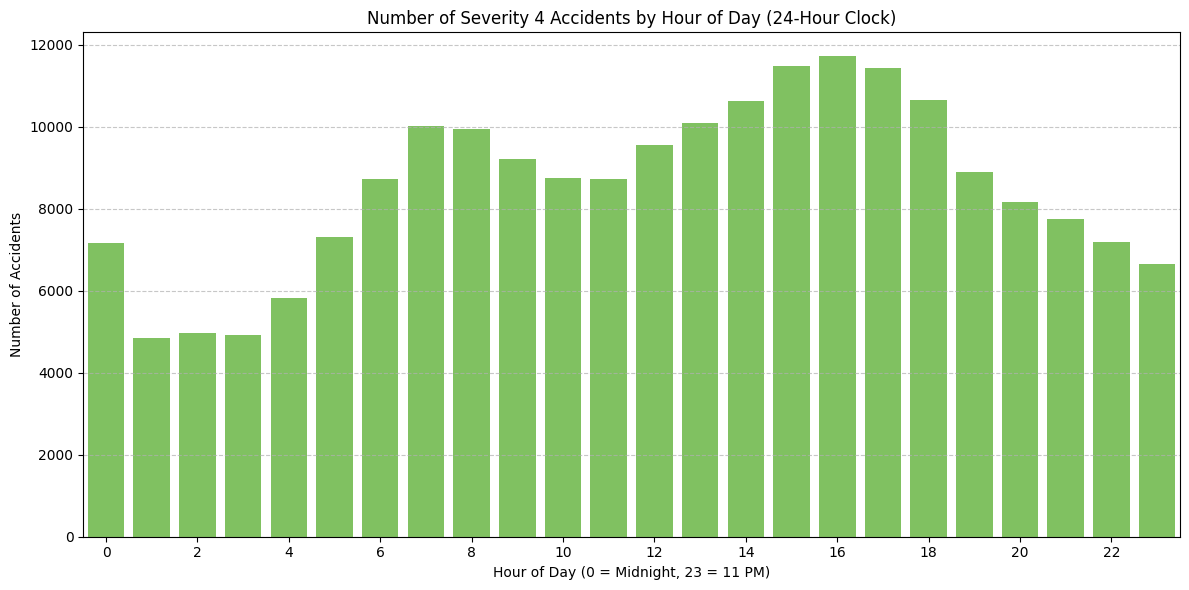

In [11]:
def plot_hourly_freq_by_sevgroup(df_spark, severity_level, plot_color):
    """
    Analyzes and plots accident frequency for a specific severity level by hour of day.
    """
    print(f"\n--- Analyzing Accident Frequency for Severity {severity_level} by Hour of Day ---")

    # Filter for the specified severity level and extract hour
    df_hourly = df_spark.filter(col("Severity") == severity_level) \
                        .withColumn("Start_Hour", hour(col("Start_Time")))

    # Count accidents per hour
    hourly_counts_spark = df_hourly.groupBy("Start_Hour").count().orderBy("Start_Hour")
    hourly_counts_pd = hourly_counts_spark.toPandas()

    # Ensure all 24 hours (0-23) are present for complete x-axis, filling missing hours with 0
    all_hours_df = pd.DataFrame({'Start_Hour': range(24)})
    hourly_counts_pd = pd.merge(all_hours_df, hourly_counts_pd, on='Start_Hour', how='left').fillna(0)

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Start_Hour', y='count', data=hourly_counts_pd, color=plot_color)

    plt.title(f'Number of Severity {severity_level} Accidents by Hour of Day (24-Hour Clock)')
    plt.xlabel('Hour of Day (0 = Midnight, 23 = 11 PM)')
    plt.ylabel('Number of Accidents')
    plt.xticks(range(0, 24, 2))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
#TODO get colors to match bar chart above
viridis_colors = sns.color_palette("viridis", 4)
sev3_color = viridis_colors[2]
sev4_color = viridis_colors[3]

plot_hourly_freq_by_sevgroup(df, 3, sev3_color)
plot_hourly_freq_by_sevgroup(df, 4, sev4_color)


--- Analyzing Accident Frequency for Severity 3 by Day of Week ---


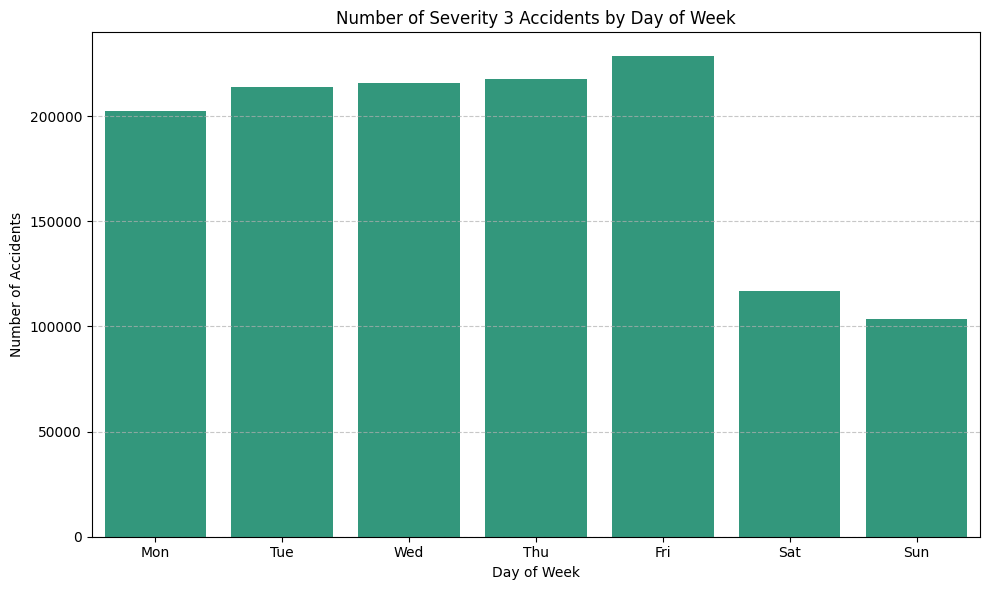


--- Analyzing Accident Frequency for Severity 4 by Day of Week ---


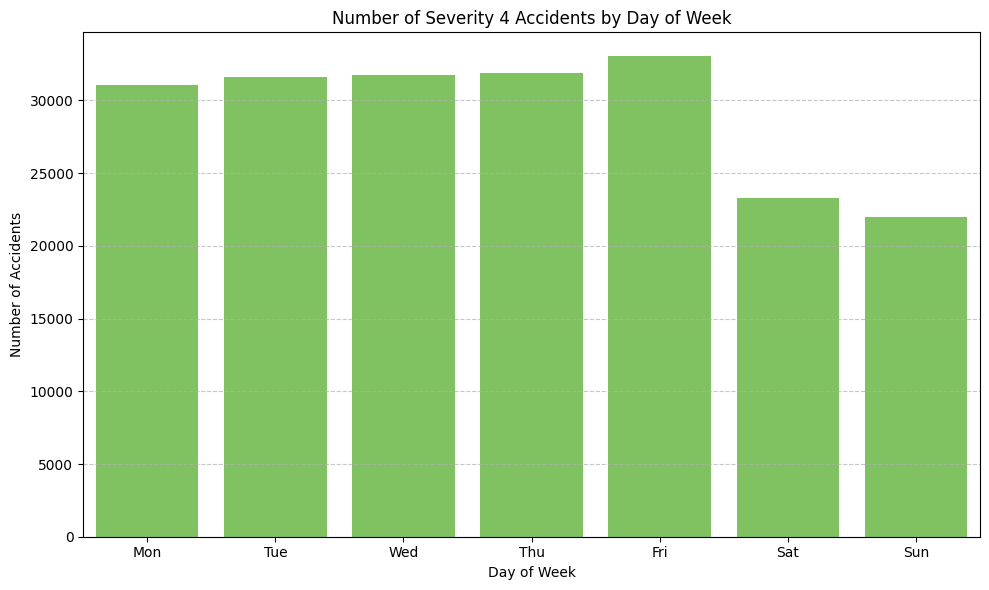

In [12]:
def plot_daily_freq_by_sevgroup(df_spark, severity_level, plot_color):
    """
    Analyzes and plots accident distribution by day of week for a specific severity
    """
    print(f"\n--- Analyzing Accident Frequency for Severity {severity_level} by Day of Week ---")

    # Filter for the specified severity level
    df_filtered_severity = df_spark.filter(col("Severity") == severity_level) \
                                 .withColumn("Day_of_Week_Num", dayofweek(col("Start_Time"))) \
                                 .withColumn("Day_of_Week", date_format(col("Start_Time"), "E"))
                                 # "E" gives abbreviated day name (Mon, Tue)

    # Count accidents per day of week
    dow_counts_spark = df_filtered_severity.groupBy("Day_of_Week_Num", "Day_of_Week").count().orderBy("Day_of_Week_Num")
    dow_counts_pd = dow_counts_spark.toPandas()

    day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"] # Keep weekend grouped
    dow_counts_pd['Day_of_Week'] = pd.Categorical(dow_counts_pd['Day_of_Week'], categories=day_order, ordered=True)
    dow_counts_pd = dow_counts_pd.sort_values('Day_of_Week')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Day_of_Week', y='count', data=dow_counts_pd, color=plot_color)

    plt.title(f'Number of Severity {severity_level} Accidents by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Accidents')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_daily_freq_by_sevgroup(df, 3, sev3_color)
plot_daily_freq_by_sevgroup(df, 4, sev4_color)
#TODO ... and further... colors maybe don't correlate well. sev4 = light green?


--- Analyzing Accident Frequency by Calendar Day ---


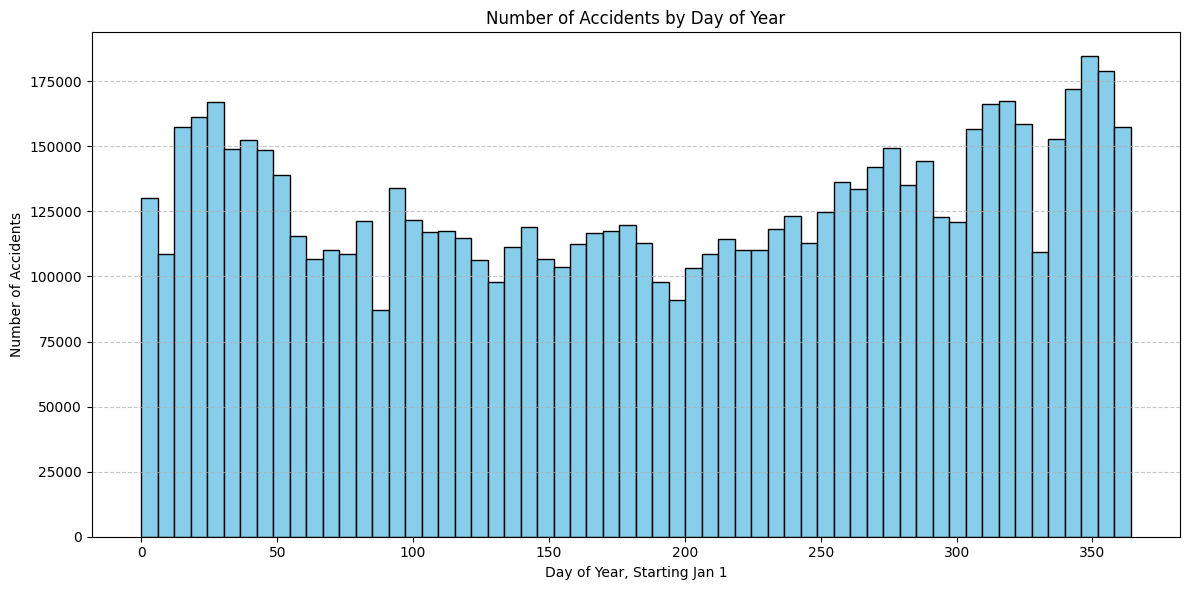

In [29]:
print("\n--- Analyzing Accident Frequency by Calendar Day ---")

df_doy_accidents = df.withColumn("Day_of_year", dayofyear(col("Start_Time")))
daily_counts_spark = df_doy_accidents.groupBy("Day_of_year").count().orderBy("Day_of_year")

daily_counts_pd = daily_counts_spark.toPandas()

all_days = pd.DataFrame({'Day_of_year': range(365)})
daily_counts_pd = pd.merge(all_days, daily_counts_pd, on='Day_of_year', how='left').fillna(0)

plt.figure(figsize=(12, 6))
plt.hist(daily_counts_pd['Day_of_year'], weights=daily_counts_pd['count'], bins=60, color='skyblue', edgecolor='black')

plt.title('Number of Accidents by Day of Year')
plt.xlabel('Day of Year, Starting Jan 1')
plt.ylabel('Number of Accidents')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


--- Accidents Per Year ---


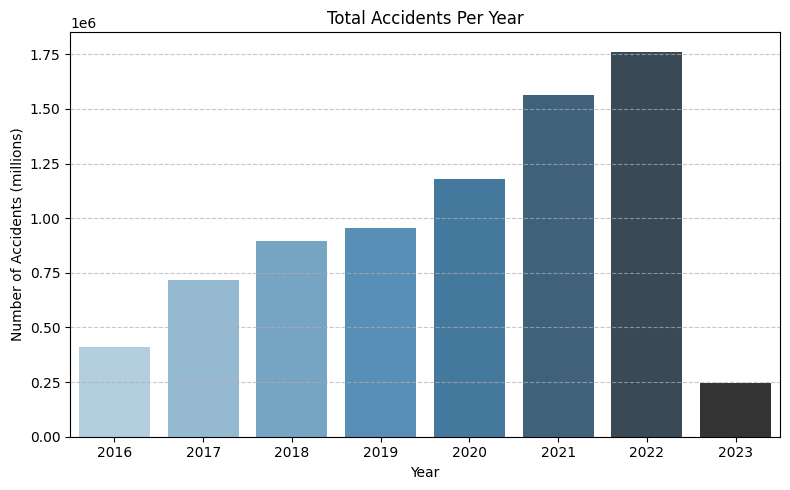

In [30]:
print("\n--- Accidents Per Year ---")
# Extract year from Start_Time
df_yearly = df.withColumn("Year", year(F.col("Start_Time")))

# Count accidents per year
yearly_counts_spark = df_yearly.groupBy("Year").count().orderBy("Year")
yearly_counts_pd = yearly_counts_spark.toPandas()

# Plot as a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x="Year", y="count", data=yearly_counts_pd, hue="Year", palette="Blues_d", legend=False)

plt.title("Total Accidents Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Accidents (millions)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


##### Time-Based EDA Comments

Accidents trending up year over year is clearly increased reporting (discussed at length in recommendations). Day of the week and day of the year both show substantial "seasonality", requiring good "apples to apples" comparisons (made questionable by yearly increase). This exploration mainly highlights the limits of the data set.

### Weather EDA

"For it is far more important to know whether there will be weather, than what the weather will be."

In [13]:
# Look at the weather data AS IS

print("--- Distribution of Weather_Condition (including missing values) ---")

weather_counts_spark = df.groupBy("Weather_Condition").count().orderBy(col("count").desc())
weather_counts_pd = weather_counts_spark.toPandas()

weather_counts_pd['Weather_Condition'] = weather_counts_pd['Weather_Condition'].fillna('Missing')

num_unique_conditions = len(weather_counts_pd['Weather_Condition'].unique())
print(f"Number of unique weather conditions (including 'Missing'): {num_unique_conditions}")

print("\nTop 15 Weather Conditions:")
print(weather_counts_pd.head(15))

# Print summary of missing values
missing_weather_count = df.filter(col("Weather_Condition").isNull()).count()
total_records = df.count()
missing_percentage = (missing_weather_count / total_records) * 100 if total_records > 0 else 0
print(f"\nMissing Weather_Condition values: {missing_weather_count} out of {total_records} ({missing_percentage:.2f}%)")

--- Distribution of Weather_Condition (including missing values) ---


Number of unique weather conditions (including 'Missing'): 145

Top 15 Weather Conditions:
   Weather_Condition    count
0               Fair  2560802
1      Mostly Cloudy  1016195
2             Cloudy   817082
3              Clear   808743
4      Partly Cloudy   698972
5           Overcast   382866
6         Light Rain   352957
7   Scattered Clouds   204829
8            Missing   173459
9         Light Snow   128680
10               Fog    99238
11              Rain    84331
12              Haze    76223
13      Fair / Windy    35671
14        Heavy Rain    32309



Missing Weather_Condition values: 173459 out of 7728394 (2.24%)


In [ ]:
with open("weather_mapping.json", "r") as f:
    weather_consolidation_map = json.load(f)

consolidated_weather_col_expr = when(col("Weather_Condition").isNull(), "Missing")

# Initial weather category groupings provided by Gemini (145 categories is a lot for a human to process)
# # Save to file (uncomment to re-create)
# with open("weather_mapping.json", "w") as f:
#     json.dump(weather_consolidation_map, f)

# Add all explicit mappings
for original_cond, new_cat in weather_consolidation_map.items():
    consolidated_weather_col_expr = consolidated_weather_col_expr.when(
        col("Weather_Condition") == original_cond,
        lit(new_cat) # Meow
    )

# Add the new consolidated column to the DataFrame
df_categorized_weather = df.withColumn("Consolidated_Weather", consolidated_weather_col_expr)

# Inspect the new categories and their counts
print("\n--- Consolidated Weather Condition Categories ---")
consolidated_counts = df_categorized_weather.groupBy("Consolidated_Weather").count().orderBy(col("count").desc())
consolidated_counts.show(truncate=False)

print(f"\nNumber of consolidated categories: {consolidated_counts.count()}")


--- Consolidated Weather Condition Categories ---


+-------------------------------+-------+
|Consolidated_Weather           |count  |
+-------------------------------+-------+
|Clear                          |3369545|
|Cloudy                         |3119944|
|Light Rain/Drizzle             |382479 |
|Fog/Mist/Haze                  |188255 |
|Missing                        |173459 |
|Light Snow                     |128750 |
|Rain (Moderate/Heavy)          |117102 |
|Windy (Clear/Cloudy)           |79455  |
|Thunderstorm                   |53064  |
|Thunderstorm with Precip/Hail  |33019  |
|Windy (Other Precip/Conditions)|26385  |
|Snow (Moderate/Heavy)          |21280  |
|Wintry Mix/Sleet/Ice           |19149  |
|Dust/Sand/Smoke                |13119  |
|Other/Unspecified              |3252   |
|Rare/Extreme                   |137    |
+-------------------------------+-------+




Number of consolidated categories: 16


## Lighting Theory

Despite best efforts, there are almost certainly some streets/road areas that have poor lighting, which would lead to extra accidents at night, and could also make cleanup efforts more difficult. To correct for the overall road danger/flow factors, we'll look for streets (highways, really) that have a particularly high ratio of night accidents to day accidents.

#### Initial Exploration of Theory

In [16]:
# Quick look to confirm intuitions about top "streets"
top_streets = (
    df.groupBy("Street")
    .count()
    .orderBy(F.desc("count"))
    .limit(20)
)

# Show results
top_streets.show()

+--------+-----+
|  Street|count|
+--------+-----+
|  I-95 N|78430|
|  I-95 S|74528|
|   I-5 N|71968|
|  I-10 E|55572|
|  I-10 W|53725|
|   I-5 S|51781|
|  I-80 W|39662|
|  I-80 E|36113|
| I-405 N|32364|
|  I-75 N|28166|
|  I-75 S|27546|
|  I-90 E|26426|
|  I-15 N|24470|
|  I-94 W|24003|
|  I-90 W|23279|
|US-101 N|20041|
|    I-95|20028|
|  I-94 E|19940|
|  I-70 E|19697|
|  I-15 S|19230|
+--------+-----+



In [17]:
# As suspected, top 'streets' are highways
df.groupBy('Sunrise_Sunset').count().show()
# Quick look at the day/night field 

+--------------+-------+
|Sunrise_Sunset|  count|
+--------------+-------+
|          NULL|  23246|
|         Night|2370595|
|           Day|5334553|
+--------------+-------+



In [18]:
# Quick exploration of those streets day/night ratios
# Convert Start_Time to Date Format
df = df.withColumn("Date", F.to_date("Start_Time"))

# Get top 20 streets as a list instead of a DataFrame
top_street_list = [row["Street"] for row in top_streets.collect()]

# Filter dataset and calculate night accident ratio
street_accident_ratios = (
    df.filter(F.col("Street").isin(top_street_list))  # Use extracted list instead of a DataFrame
    .filter(F.col("Sunrise_Sunset").isNotNull())  # Exclude missing values
    .groupBy("Street")
    .agg(
        F.count("*").alias("Total_Accidents"),
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", 1).otherwise(0)).alias("Night_Accidents")
    )
    .withColumn("Night_Ratio", F.col("Night_Accidents") / F.col("Total_Accidents"))
    .orderBy(F.desc("Night_Ratio"))
)

street_accident_ratios.show(20, truncate=False)

+--------+---------------+---------------+-------------------+
|Street  |Total_Accidents|Night_Accidents|Night_Ratio        |
+--------+---------------+---------------+-------------------+
|I-90 W  |23235          |9371           |0.4033139659995696 |
|I-90 E  |26382          |10517          |0.39864301417633236|
|I-94 E  |19934          |7624           |0.3824621250125414 |
|I-5 S   |51781          |18925          |0.36548154728568394|
|I-94 W  |23984          |8600           |0.35857238158772514|
|I-80 W  |39658          |14060          |0.3545312421201271 |
|I-5 N   |71968          |25264          |0.3510449088483771 |
|I-95    |19222          |6742           |0.35074393923629177|
|I-80 E  |36095          |12648          |0.35040864385648984|
|I-15 S  |19204          |6601           |0.3437304728181629 |
|I-10 E  |55561          |18303          |0.3294217166717662 |
|I-10 W  |53725          |17499          |0.32571428571428573|
|US-101 N|20041          |6483           |0.32348685195

In [20]:
# Indeed, some highways show a pattern of more accidents at night
# However, just saying "I-95 needs more lighting" will be useless
# Let's find segments where lighting may be a particular issue
top_street_list = [row["Street"] for row in top_streets.collect()]

# Filter dataset for top streets aka highways
df_filtered = df.filter(F.col("Street").isin(top_street_list))

county_ratios = (
    df_filtered.groupBy("Street", "County")
    .agg(
        F.count("*").alias("Total_Accidents"),
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", 1).otherwise(0)).alias("Night_Accidents")
    )
    .withColumn("Night_Ratio", F.col("Night_Accidents") / F.col("Total_Accidents"))
)

county_ratios_dict = {
    row["Street"]: [] for row in county_ratios.select("Street").distinct().collect()
}

for row in county_ratios.collect():
    county_ratios_dict[row["Street"]].append((row["County"], row["Total_Accidents"], row["Night_Accidents"], row["Night_Ratio"]))

# Convert list of tuples to DataFrame for easier manipulation

for highway in county_ratios_dict.keys():
    county_ratios_dict[highway] = pd.DataFrame(
        county_ratios_dict[highway], 
        columns=["County", "Total_Accidents", "Night_Accidents", "Night_Ratio"]
    ).sort_values(by="Night_Ratio", ascending=False)

# Sample output
print(county_ratios_dict["I-95"])

                 County  Total_Accidents  Night_Accidents  Night_Ratio
9            Darlington                1                1     1.000000
25               Jasper                1                1     1.000000
2   Western Connecticut                8                6     0.750000
68           Washington               22               14     0.636364
64          Northampton               33               21     0.636364
..                  ...              ...              ...          ...
67       Emporia (City)               22                2     0.090909
17             St Johns              499               10     0.020040
26          Westchester                6                0     0.000000
50            Middlesex                1                0     0.000000
71            Effingham                1                0     0.000000

[73 rows x 4 columns]


#### Lighting Exploration

Overall, this is a promising area of analysis. Representation is very uneven, so we will have to carefully balance the absolute vs relative numbers. Ultimately, it will be up to USDOT stakeholders to decide if, for example, an area (county) with 0 day accidents and 5 night accidents is more in need of lighting upgrades than an area with 20 day accidents and 40 night accidents.

#### Next Steps

We considered whether it makes sense to group I-95 N with I-95 S. For narrower highways, lighting along the median should provide a symmetrical outcome, but for wider highways, there may be a genuine difference. We decided to group these together for simplicity. This also solves the problem of some accidents being labeled as just "I-95" e.g.

 1. Consolidate highway 'directions'.
 2. Find the top 20 highways by total number of accidents
 3. Per street, calculate a "Severity Score" for day and night, as well as the ratio. This gives us the overall information and allows us to find "dark spots" along a particular highway.
 4. For each street, analyze county by county to find those "dark spots"

(Some steps from the Exploration phase are repeated - this is intentional)

#### Severity Score

Without external direction, it is hard to determine the actual impact on traffic, theoretically estimated in person-hours. An accident that takes 1 hour to clear on a minor road may delay 200 people (~200 person-hours). An accident that takes 15 minutes to clear on a major highway might delay 4,000 people (~1000 person hours). We are assuming that the current severity ratings take these factors into account and, because of the limited number of categories, likely operate on a roughly exponential scale. Specific input from USDOT stakeholders could tune this score to be more in line with their observations.

In [21]:
# Define a function to remove directional markers from street names
def clean_street_name(street):
    return re.sub(r'\s[NSEW]$', '', street) if street else street

# Register function as a Spark User Defined Function
clean_street_udf = F.udf(clean_street_name)

# Apply function to create new column
df = df.withColumn("Street_minus_dir", clean_street_udf(F.col("Street")))

# Aggregate data by Street_minus_dir
merged_streets = (
    df.groupBy("Street_minus_dir")
    .agg(
        F.count("*").alias("Total_Accidents"),
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", 1).otherwise(0)).alias("Night_Accidents")
    )
    .withColumn("Night_Ratio", F.col("Night_Accidents") / F.col("Total_Accidents"))
    .orderBy(F.desc("Night_Ratio"))
)

# Convert results into dictionary for easy lookup
merged_streets_dict = {
    row["Street_minus_dir"]: (row["Total_Accidents"], row["Night_Accidents"], row["Night_Ratio"])
    for row in merged_streets.collect()
}

# Sample lookup
merged_streets_dict["I-95"]

(172986, 55006, 0.31797948966968426)

In [22]:
# Sort merged_streets_dict by Total_Accidents in descending order
sorted_streets_by_total = sorted(merged_streets_dict.items(), key=lambda x: x[1][0], reverse=True)

# Extract the top 20 highways
top_20_highways_by_total_accidents = dict(sorted_streets_by_total[:20])

# Sample output to verify
for street, stats in top_20_highways_by_total_accidents.items():
    print(f"{street}: Total Accidents={stats[0]}, Night Accidents={stats[1]}, Night Ratio={stats[2]}")

I-95: Total Accidents=172986, Night Accidents=55006, Night Ratio=0.31797948966968426
I-5: Total Accidents=134766, Night Accidents=48235, Night Ratio=0.35791668521733966
I-10: Total Accidents=123536, Night Accidents=41031, Night Ratio=0.3321380002590338
I-80: Total Accidents=87004, Night Accidents=30915, Night Ratio=0.3553284906441083
I-75: Total Accidents=68886, Night Accidents=21017, Night Ratio=0.30509827831489705
I-405: Total Accidents=54300, Night Accidents=17188, Night Ratio=0.3165377532228361
I-15: Total Accidents=53025, Night Accidents=17663, Night Ratio=0.3331070249882131
I-90: Total Accidents=50497, Night Accidents=20168, Night Ratio=0.39939006277600647
I-40: Total Accidents=47011, Night Accidents=14504, Night Ratio=0.3085235370445215
I-94: Total Accidents=46165, Night Accidents=16970, Night Ratio=0.36759449799631755
I-70: Total Accidents=44089, Night Accidents=14394, Night Ratio=0.3264759917439724
US-101: Total Accidents=39330, Night Accidents=13232, Night Ratio=0.33643529112

In [ ]:
df = df.withColumn("Severity_Score", 
    F.when(F.col("Severity") == 1, 1)
    .when(F.col("Severity") == 2, 2)
    .when(F.col("Severity") == 3, 4)
    .when(F.col("Severity") == 4, 8)
)
df.groupBy("Severity_Score").count().show() 
# ^^ just a sanity check that should align with overall distribution
#TODO - move to data cleaning/prep

+--------------+-------+
|Severity_Score|  count|
+--------------+-------+
|             1|  67366|
|             4|1299337|
|             8| 204710|
|             2|6156981|
+--------------+-------+



In [ ]:
# Filter dataset for top 20 highways
df_top20 = df.filter(F.col("Street_minus_dir").isin(list(top_20_highways_by_total_accidents.keys())))

# Compute severity *scores* per highway
highway_severity = (
    df_top20.groupBy("Street_minus_dir")
    .agg(
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", F.col("Severity_Score")).otherwise(0)).alias("Night_Severity"),
        F.sum("Severity_Score").alias("Total_Severity")
    )
    .withColumn("Night_Severity_Ratio", F.col("Night_Severity") / F.col("Total_Severity"))
)

# Compute overall severity scores for the entire top 20 group - this will give us a baseline.
overall_severity = (
    highway_severity.select(
        F.sum("Night_Severity").alias("Group_Night_Severity"),
        F.sum("Total_Severity").alias("Group_Total_Severity")
    )
)

# Compute the group-wide night severity ratio
overall_severity_ratio = overall_severity.collect()[0]["Group_Night_Severity"] / overall_severity.collect()[0]["Group_Total_Severity"]

# Convert highway severity results to dictionary for reference
highway_severity_dict = {
    row["Street_minus_dir"]: (row["Night_Severity"], row["Total_Severity"], row["Night_Severity_Ratio"])
    for row in highway_severity.collect()
}

# Sample lookup
print(f"Group-wide Night Severity Ratio: {overall_severity_ratio}")
print(highway_severity_dict.get("I-95", "Highway not found"))

Group-wide Night Severity Ratio: 0.33162503760648027
(153350, 488848, 0.3136966909959742)


In [ ]:
# COUNTY analysis
# Compute severity scores per highway & county
county_severity = (
    df_top20.groupBy("Street_minus_dir", "County")
    .agg(
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", F.col("Severity_Score")).otherwise(0)).alias("Night_Severity"),
        F.sum("Severity_Score").alias("Total_Severity")
    )
    .withColumn("Night_Severity_Ratio", F.col("Night_Severity") / F.col("Total_Severity"))
)

# Convert to dictionary for reference
county_severity_dict = {
    row["Street_minus_dir"]: [] for row in county_severity.select("Street_minus_dir").distinct().collect()
}

for row in county_severity.collect():
    county_severity_dict[row["Street_minus_dir"]].append(
        (row["County"], row["Night_Severity"], row["Total_Severity"], row["Night_Severity_Ratio"])
    )

# Convert lists of tuples to DataFrames
for highway in county_severity_dict.keys():
    county_severity_dict[highway] = pd.DataFrame(
        county_severity_dict[highway], 
        columns=["County", "Night_Severity", "Total_Severity", "Night_Severity_Ratio"]
    ).sort_values(by="Night_Severity_Ratio", ascending=False)

# Sample lookup
print(county_severity_dict["I-95"])


                       County  Night_Severity  Total_Severity  \
40        Western Connecticut              12              18   
99  South Central Connecticut              12              20   
96                  Effingham              20              38   
57                    Fairfax             528            1054   
29                      Bronx             316             686   
..                        ...             ...             ...   
7                        Kent             972            4742   
44                   Kennebec              66             386   
94                  Aroostook               6              50   
97             Emporia (City)               4              50   
55                   St Johns              21            1076   

    Night_Severity_Ratio  
40              0.666667  
99              0.600000  
96              0.526316  
57              0.500949  
29              0.460641  
..                   ...  
7               0.204977  
44 

In [25]:
# Convert to list, take a quick look

highway_list = list(top_20_highways_by_total_accidents.keys())
highway_list

['I-95',
 'I-5',
 'I-10',
 'I-80',
 'I-75',
 'I-405',
 'I-15',
 'I-90',
 'I-40',
 'I-94',
 'I-70',
 'US-101',
 'I-84',
 'I-64',
 'CA-99',
 'I-35',
 'I-85',
 'I-20',
 'I-65',
 'CA-60']

In [26]:
# Filter dataset for chosen top highways
df_selected = df.filter(F.col("Street_minus_dir").isin(highway_list))

# Aggregate data per street/county/state using weighted severity scores
aggregated_data = (
    df_selected.groupBy("Street_minus_dir", "County", "State")
    .agg(
        F.avg("Start_Lat").alias("Latitude"),  # Approximate central location
        F.avg("Start_Lng").alias("Longitude"),
        F.sum("Severity_Score").alias("Total_Severity_Score"),
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", F.col("Severity_Score")).otherwise(0)).alias("Night_Severity_Score"),
        F.sum(F.when(F.col("Sunrise_Sunset") == "Night", 1).otherwise(0)).alias("Night_Accident_Count"),
        (F.sum(F.when(F.col("Sunrise_Sunset") == "Night", F.col("Severity_Score")).otherwise(0)) / F.sum("Severity_Score")).alias("Night_SevScore_Ratio")
    )
)

# Set output directory
output_dir = "created_data"
os.makedirs(output_dir, exist_ok=True)

# Export to CSV
aggregated_data.toPandas().to_csv(f"{output_dir}/highway_severity_summary.csv", index=False)

print("CSV export completed.")

CSV export completed.


## Winter Weather Prep

Hypothesis - winter weather events are particularly impactful in states where they are rare

In [30]:
print("\n--- Accident Distribution by State ---")

# Aggregate accident counts by state
accidents_by_state = df.groupBy("State").count().toPandas()
accidents_by_state.columns = ["State", "Accident_Count"]

# Sort for better readability
accidents_by_state = accidents_by_state.sort_values(by="Accident_Count", ascending=False)

# Print table
print(accidents_by_state)


--- Accident Distribution by State ---


   State  Accident_Count
10    CA         1741433
27    FL          880192
23    TX          582837
0     SC          382557
22    NY          347960
34    NC          338199
4     VA          303301
21    PA          296620
30    MN          192084
3     OR          179660
28    AZ          170609
25    GA          169234
16    IL          168958
40    TN          167388
8     MI          162191
29    LA          149701
1     NJ          140719
13    MD          140417
19    OH          118115
17    WA          108221
39    AL          101044
46    UT           97079
43    CO           90885
45    OK           83647
15    MO           77323
12    CT           71005
18    IN           67224
26    MA           61996
9     WI           34688
6     KY           32254
11    NE           28870
47    MT           28496
20    IA           26307
44    AR           22780
32    NV           21665
42    KS           20992
2     DC           18630
5     RI           16971
38    MS           15181
